# Predicting stock closing price from stock data using the Hidden Markov Model to identify latent states

## Hidden Markov Model

A Hidden Markov Model, or HMM for short, may be thought of as a double stochastic process:
1. A hidden or latent Markov stochastic process
2. An observable stochastic process that produces sequences of observations

Since HMMs are often used to capture long-term sequences and hence time-based phenomena, they may prove to be useful in analysis of financial markets.

## Goal

We are going to take the features of opening price, low price, high price and use these to derive some fractional changes. With these fractional changes, we will observe sequences (observations) from which we will derive latent factors in a Markov process. These latent factors will often vary from company to company, which is why it's often hard to fit one linear model of a certain subset of variables for all companies. Once the latent factors and their transitions and starting probabilities (the hidden sequence) are found, we will try to generate some possible values for each of the features and then check how they score with a sequence of test data. The set of possible values that leads to the highest score is then used to predict the closing price for that day.

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Install YFinance to directly download company stock info instead of uploading and using a CSV

The YFinance module neatly downloads company stock data in the form of a Pandas DataFrame and saves us the trouble of uploading custom CSVs. The same effect can be observed for custom CSVs although a different subset of column names will then have to be assigned.

In [ ]:
%pip install yfinance

In [ ]:
import yfinance as yf
import datetime
import time
import requests
import io

## Get ^GSPC data

The S&P 500 index, or Standard & Poor’s 500, is a very important index that tracks the performance of the stocks of 500 large-cap companies in the U.S. The ticker symbol for the S&P 500 index is ^GSPC.

We are going to download data from 2000 onwards. If we start from 2010, we get very little data to fit our model on and that may lead to inaccurate transition probabilities in the hidden Markov process.

In [ ]:
data = yf.download("^GSPC", start="2000-01-01", end="2021-08-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [ ]:
data.shape

(5429, 6)

## Preprocessing

For the GSPC data from 1st January, 2000 to 1st August, 2021, there are 5429 entries.

### Train-test split

For all data, we are going to do a 80-20 train-test split.

In [ ]:
train_size = int(0.8*data.shape[0])
print(train_size)

4343


In [ ]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

### Extracting features



We are going to be working with 3 features:
1. The fractional change in opening and closing prices (fracocp)
2. The fractional change in high prices (frachp)
3. The fractional change in low prices (fraclp)

These will be obtained individually in the train and test datasets.

In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
features = extract_features(augment_features(train_data))

In [ ]:
features.shape

(4343, 3)

## Hidden Markov Models with hmmlearn

### Model

We are first going to import the GaussianHMM from hmmlearn.hmm and then fit it with 10 hidden components (or states) to our training data. We start off with 10 hidden states, but it may be possible to do a grid search among a possible set of values for the number of hidden states to see which works the best.

In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
from hmmlearn.hmm import GaussianHMM

In [ ]:
model = GaussianHMM(n_components=10)

In [ ]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

### Generating possible sequences

To generate possible possible permutations of values for the features we take the Cartesian product across a range of values for each feature as seen below. We assume a few things here to reduce model complexity.
1. We assume that the distribution of each features is across an evenely spaced interval instead of being fully continuous
2. We assume possible values for the start and end of the intervals

In [ ]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

### Checking predictions

We use the data of the last 50 (latent) days to predict the closing price of the current day, and we repeat those for 300 days (this value does not matter at all)

In [ ]:
num_latent_days = 50
num_days_to_predict = 300

For each of the days that we are going to predict closing prices for, we are going to take the test data for the previous num_latent_days and try each of the outcomes in possible_outcomes to see which sequence generates the highest score. The outcome that generates the highest score is then used to make the predictions for that day's closing price.

In [ ]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [10:23<00:00,  2.08s/it]


Plotting the predicted closing prices and the actual closing prices, we see the following

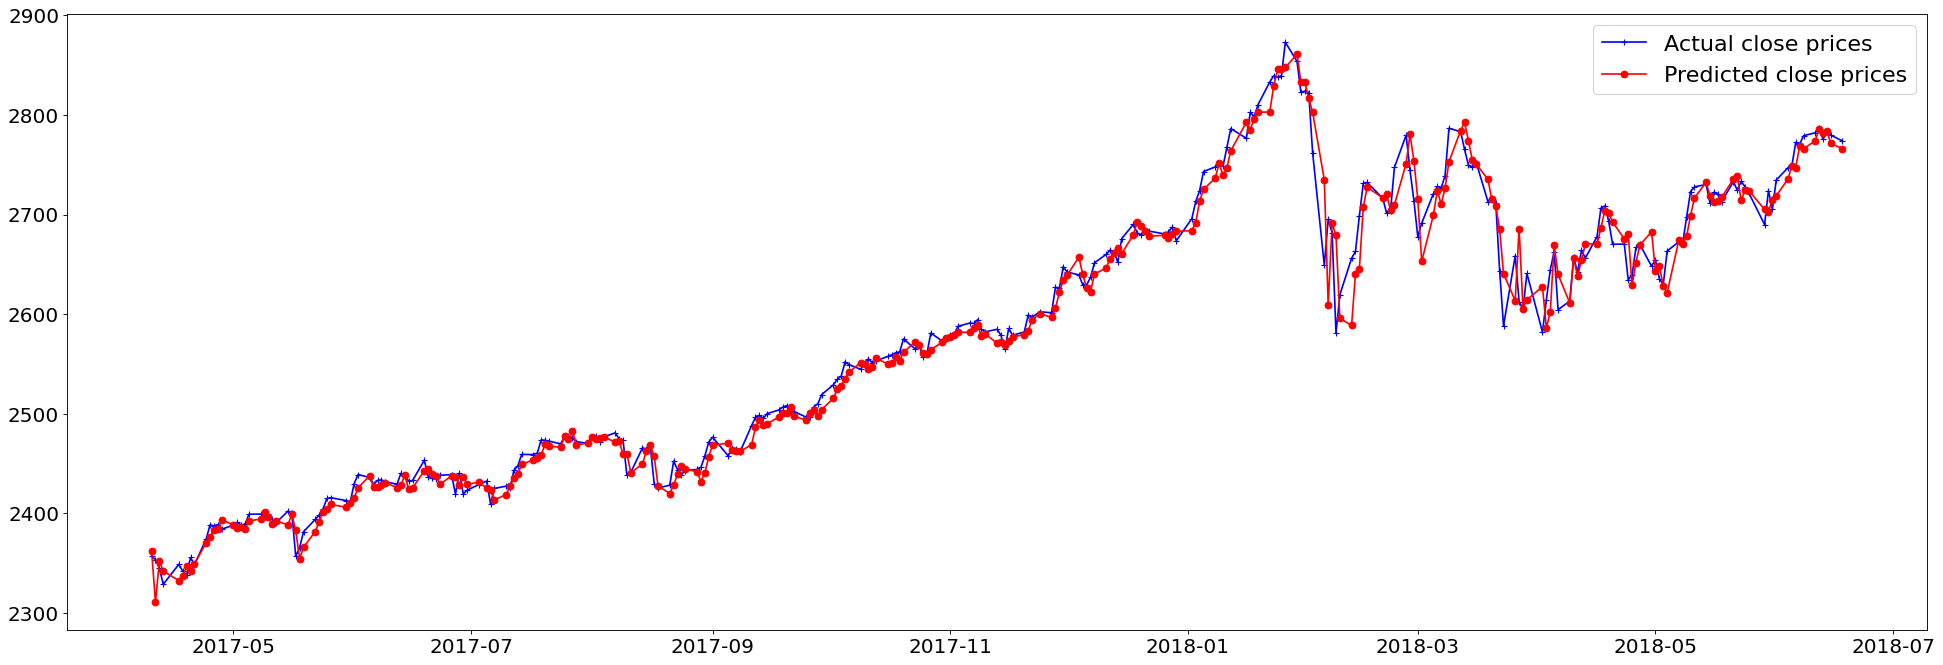

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

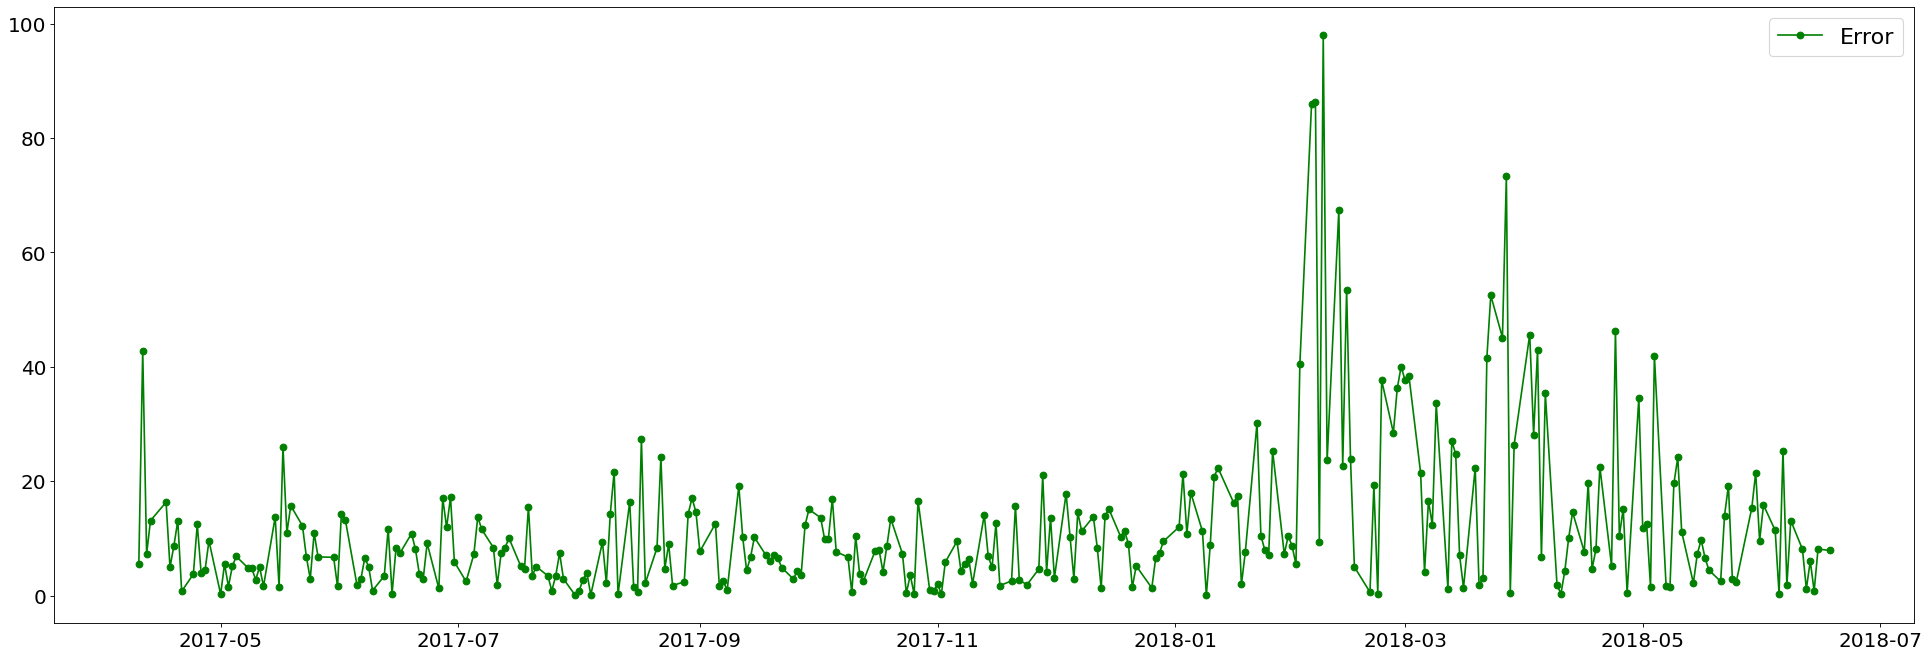

In [ ]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 97.95696185860197
Min error observed = 0.05535100330644127
Mean error observed = 11.87892429710844


The graphs above show that our model is fairly accurate in predicting the close prices. There is a maximum absolute error of 104.09, a minimum absolute error of 0.05 and a mean absolute error of 10.6812.76. The first graph also shows that there are not very significant gaps between the predictions plot and the actual plot.

We also observe that the highest errors occur when the actual closing prices change very sharply (steep rise or fall).

However, we can say that our model is able to predict the general trends in the actual closing price movement fairly well, although there are lags observed from time to time.

**Gaussian HMM**




A Gaussian Hidden Markov Model (HMM) differs from a standard Hidden Markov Model (HMM) in the type of probability distributions used to model emissions and transitions. While a standard HMM allows for arbitrary probability distributions, Gaussian HMM specifically employs Gaussian (normal) distributions for emissions and transitions. This means that the observations emitted by each hidden state and the transition probabilities between states are described using Gaussian distributions, simplifying the model's representation and computation while making it particularly suitable for data with continuous features.

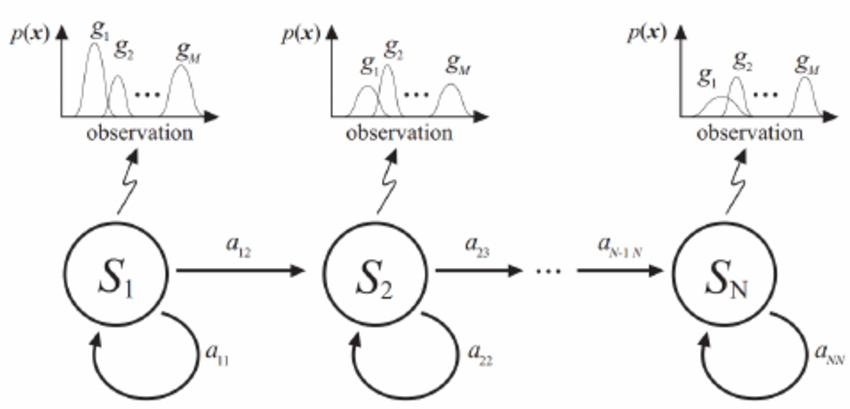

## Tweaking some hyperparameters

We will be doing some graphs across a range of values for num_latent_days, n_components, and varying the steps in the interval that the features take

In [ ]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 6, 8, 10, 12, 14]
baseline_n_componets = 10
num_steps_values = [10, 20, 40, 50]
baseline_num_steps = 50
num_days_to_predict = 100 # We don't need to predict as many days as before

### Comparing across different values for num_components

In [ ]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())


In [ ]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

Here we notice that we are able to improve our prediction (as indicated by the lower MAE) going from 4 hidden states to 10, but beyond that there is no significant improvement in the prediction. This leads us to believe that the observations (combination of 3 features) are controlled by 10 hidden states and the emissions of these hidden states.

There is also a tradeoff between time to make a prediction and the number of hidden states or components in the model, and so it would make the most sense, to stick to just 10 components (our baseline with which we achieved the overall results).

### Comparing across different number of intervals for the feature variables

In [ ]:
mae_num_steps = []
model = GaussianHMM(n_components=baseline_n_componets)
model.fit(features_train)
for num_step in num_steps_values:
    sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_steps.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

In [ ]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(num_steps_values, mae_num_steps, 'go-', label="Error")
plt.xlabel("Number of intervals for features")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

# Summary
Here we tried to vary the number of steps in the interval range for each of the features. Intuitively, the finer the interval (a higher number of steps), the closer the distribution gets to becoming continuous and the more accurate a candidate observation may possibly be. However in making the distribution close to continuous, we have to compute the score (or the likelihood of a candidate observation given previous observations) of a much larger number of possible candidate observations and that would require a large amount of computational resources.

It is seen above that with a higher number of intervals, the mean absolute error decreases.